<a href="https://colab.research.google.com/github/darkraithromb/next-platform-starter/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-2-9983ccac83a9>:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])
<ipython-input-2-9983ccac83a9>:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  deaths_long['Date'] = pd.to_datetime(deaths_long['Date'])
<ipython-input-2-9983ccac83a9>:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  recovered_long['Date'] = pd.to_datetime(recovered_long['Date'])


Gradient Boosting - MSE: 2595658673986.3047, MAE: 393147.78368297714
XGBoost - MSE: 1798308578491.4636, MAE: 327174.41078232566
Ridge Regression - MSE: 1141895017207.9888, MAE: 448074.3642049904


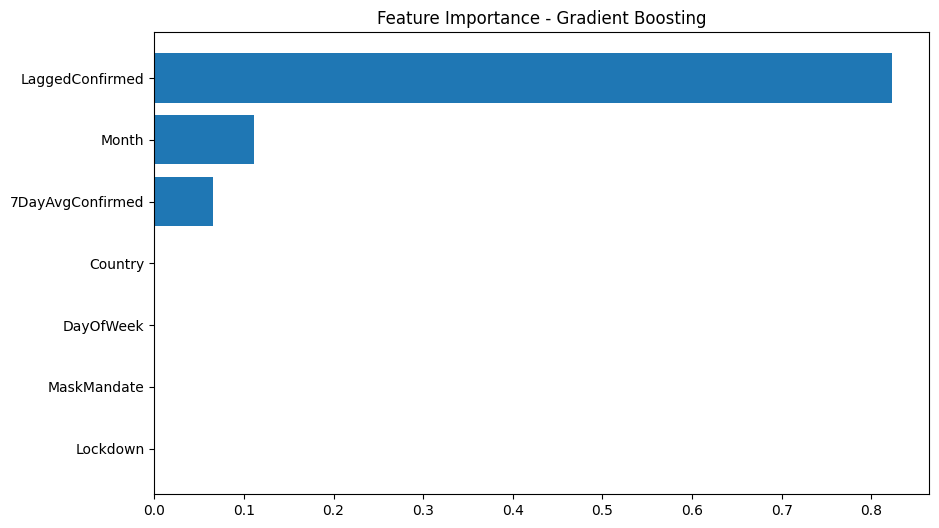

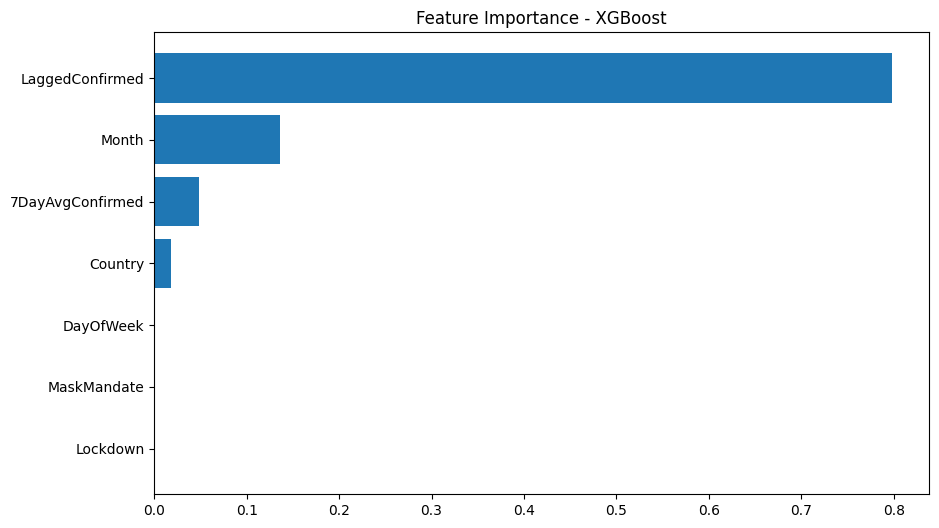

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import statsmodels.api as sm

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Convert data to long format
confirmed_long = pd.melt(df_confirmed, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
deaths_long = pd.melt(df_deaths, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
recovered_long = pd.melt(df_recovered, id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert 'Date' to datetime
confirmed_long['Date'] = pd.to_datetime(confirmed_long['Date'])
deaths_long['Date'] = pd.to_datetime(deaths_long['Date'])
recovered_long['Date'] = pd.to_datetime(recovered_long['Date'])

# Aggregate data by country and date
confirmed_agg = confirmed_long.groupby(['Country/Region', 'Date']).agg({'Confirmed': 'sum'}).reset_index()
deaths_agg = deaths_long.groupby(['Country/Region', 'Date']).agg({'Deaths': 'sum'}).reset_index()
recovered_agg = recovered_long.groupby(['Country/Region', 'Date']).agg({'Recovered': 'sum'}).reset_index()

# Merge dataframes
data = confirmed_agg.merge(deaths_agg, on=['Country/Region', 'Date'])
data = data.merge(recovered_agg, on=['Country/Region', 'Date'])

# Feature Engineering
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Month'] = data['Date'].dt.month
data['LaggedConfirmed'] = data['Confirmed'].shift(1).fillna(0)
data['7DayAvgConfirmed'] = data['Confirmed'].rolling(window=7).mean().fillna(0)

# Encode categorical variables
label_encoder = LabelEncoder()
data['Country'] = label_encoder.fit_transform(data['Country/Region'])

# Add government interventions (example dates)
lockdown_dates = pd.to_datetime(['2020-03-20', '2020-04-15'])
mask_mandate_dates = pd.to_datetime(['2020-04-01'])

data['Lockdown'] = data['Date'].apply(lambda x: 1 if x in lockdown_dates else 0)
data['MaskMandate'] = data['Date'].apply(lambda x: 1 if x in mask_mandate_dates else 0)

# Handle outliers using z-score
from scipy import stats
data = data[(np.abs(stats.zscore(data[['Confirmed']])) < 3).all(axis=1)]

# Split data into train and test sets
split_date = '2021-01-01'
train_data = data[data['Date'] < split_date]
test_data = data[data['Date'] >= split_date]

features = ['LaggedConfirmed', '7DayAvgConfirmed', 'DayOfWeek', 'Month', 'Lockdown', 'MaskMandate', 'Country']
target = 'Confirmed'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model 1: Gradient Boosting Regressor with GridSearchCV
param_grid_gbr = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gbr_model = GradientBoostingRegressor(random_state=42)
gbr_grid_search = GridSearchCV(gbr_model, param_grid_gbr, cv=TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
gbr_grid_search.fit(X_train_scaled, y_train)

# Model 2: XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=7, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Model 3: Ridge Regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Predictions and Evaluation
models = {
    'Gradient Boosting': gbr_grid_search.best_estimator_,
    'XGBoost': xgb_model,
    'Ridge Regression': ridge_model
}

for model_name, model in models.items():
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f'{model_name} - MSE: {mse}, MAE: {mae}')

# Feature Importance for tree-based models
if isinstance(gbr_grid_search.best_estimator_, GradientBoostingRegressor):
    plt.figure(figsize=(10, 6))
    feature_importance = gbr_grid_search.best_estimator_.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
    plt.title('Feature Importance - Gradient Boosting')
    plt.show()

if isinstance(xgb_model, XGBRegressor):
    plt.figure(figsize=(10, 6))
    feature_importance = xgb_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])
    plt.title('Feature Importance - XGBoost')
    plt.show()


!pip install prophet
!pip install streamlit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For Time Series Modeling
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
# URLs for the datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Load datasets
df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Display the first few rows of the confirmed cases dataset
df_confirmed.head()
# Melt the dataframes to have a format of Country/Region, Date, and Cases
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                                 var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                           var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                                 var_name='Date', value_name='Recovered')

# Convert the Date column to datetime format
# Convert the Date column to datetime format
df['LaggedConfirmed_7'] = df['Confirmed'].shift(7).fillna(0) # Changed 'data' to 'df'
df['LaggedConfirmed_14'] = df['Confirmed'].shift(14).fillna(0) # Changed 'data' to 'df'

# Add rolling averages with different windows
df['30DayAvgConfirmed'] = df['Confirmed'].rolling(window=30).mean().fillna(0) # Changed 'data' to 'df'
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Add rolling averages with different windows
df['30DayAvgConfirmed'] = df['Confirmed'].rolling(window=30).mean().fillna(0)
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the dataframes on Country/Region, Province/State, Lat, Long, and Date
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Handle missing values if necessary
df.fillna(0, inplace=True)

# Display the first few rows of the merged dataframe
df.head()
# Group by Date and sum up the cases
# Group by Date and sum up the cases
global_df = df.groupby('Date').sum(numeric_only=True).reset_index() # Add numeric_only=True to ensure only numerical columns are summed

# Plot the global trend of confirmed, deaths, and recovered cases
plt.figure(figsize=(14, 7))
plt.plot(global_df['Date'], global_df['Confirmed'], label='Confirmed', color='blue')
plt.plot(global_df['Date'], global_df['Deaths'], label='Deaths', color='red')
plt.plot(global_df['Date'], global_df['Recovered'], label='Recovered', color='green')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Global COVID-19 Trend')
plt.legend()
plt.show()
# Select a specific country, e.g., the United States
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Plot the trend for the selected country
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'], country_df['Confirmed'], label='Confirmed', color='blue')
plt.plot(country_df['Date'], country_df['Deaths'], label='Deaths', color='red')
plt.plot(country_df['Date'], country_df['Recovered'], label='Recovered', color='green')
plt.xlabel('Date')
plt.ylabel(f'Number of Cases in {country}')
plt.title(f'COVID-19 Trend in {country}')
plt.legend()
plt.show()
# Example: Calculate the daily new cases, deaths, and recoveries
# Example: Calculate the daily new cases, deaths, and recoveries
country_df['Daily New Confirmed'] = country_df['Confirmed'].diff().fillna(0)
country_df['Daily New Deaths'] = country_df['Deaths'].diff().fillna(0)
country_df['Daily New Recovered'] = country_df['Recovered'].diff().fillna(0)

# Add government interventions (example dates) - MOVED FROM PREVIOUS CODE
lockdown_dates = pd.to_datetime(['2020-03-20', '2020-04-15'])
mask_mandate_dates = pd.to_datetime(['2020-04-01'])

country_df['Lockdown'] = country_df['Date'].apply(lambda x: 1 if x in lockdown_dates else 0)
country_df['MaskMandate'] = country_df['Date'].apply(lambda x: 1 if x in mask_mandate_dates else 0)

# Display the modified dataframe
country_df.head()

# Prepare the data for Prophet
# Prepare the data for Prophet
prophet_df = country_df[['Date', 'Confirmed', 'Lockdown', 'MaskMandate']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})
prophet_model = Prophet()
prophet_model.add_regressor('Lockdown')
prophet_model.add_regressor('MaskMandate')
prophet_model.fit(prophet_df)

# Make future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=30)

# Add the Lockdown and MaskMandate columns to the future dataframe
# Add the Lockdown and MaskMandate columns to the future dataframe
future['Lockdown'] = 0 # Set a default value of 0
future['MaskMandate'] = 0 # Set a default value of 0
future.loc[future['ds'].isin(country_df['Date']), 'Lockdown'] = country_df['Lockdown'].values
future.loc[future['ds'].isin(country_df['Date']), 'MaskMandate'] = country_df['MaskMandate'].values
future['Lockdown'] = country_df['Lockdown'].iloc[-30:].values
future['MaskMandate'] = country_df['MaskMandate'].iloc[-30:].values


# Make predictions
forecast = prophet_model.predict(future)

# ... (rest of your code) ...

# Evaluate the model (you can use cross-validation as well)
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(prophet_model, initial='730 days', period='180 days', horizon = '365 days')
df_p = performance_metrics(df_cv)
print(df_p.head())

# Plot the forecast
fig1 = prophet_model.plot(forecast)
plt.show()
# ... (rest of your code) ...
# Initialize and fit the model
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Create future dates to predict
future = prophet_model.make_future_dataframe(periods=30)  # predict 30 days into the future
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title(f'COVID-19 Cases Forecast in {country} using Prophet')
plt.xlabel('Date')
plt.ylabel('Predicted Confirmed Cases')
plt.show()
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

# Perform cross-validation
df_cv = cross_validation(prophet_model, initial='180 days', period='30 days', horizon='30 days')
df_p = performance_metrics(df_cv)

# Display performance metrics
print(df_p.head())
import streamlit as st

st.title(f'COVID-19 Analysis and Forecasting for {country}')
st.line_chart(country_df[['Date', 'Confirmed', 'Deaths', 'Recovered']].set_index('Date'))
st.pyplot()  # Show the Prophet forecast plot


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/q5plp980.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/f8xo02yu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85106', 'data', 'file=/tmp/tmpz_s60dwc/q5plp980.json', 'init=/tmp/tmpz_s60dwc/f8xo02yu.json', 'output', 'file=/tmp/tmpz_s60dwc/prophet_modelktmwz2kj/prophet_model-20240901062308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


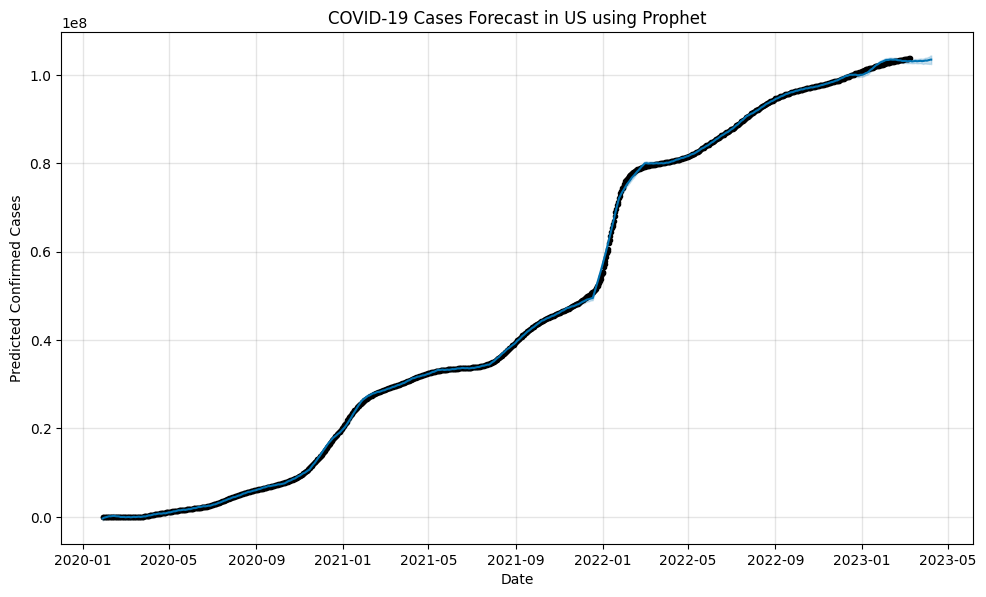

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/q6vuvr5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/f61k87nl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33550', 'data', 'file=/tmp/tmpz_s60dwc/q6vuvr5v.json', 'init=/tmp/tmpz_s60dwc/f61k87nl.json', 'output', 'file=/tmp/tmpz_s60dwc/prophet_modelojpjottm/prophet_model-20240901062313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Average MSE from Cross-Validation: 164021822300691.8
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.1177
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0014
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.9863e-05
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 7.9384e-05
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.1918e-05
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 9.2803e-05
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 7.8370e-05
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 7.9307e-05
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 9.2185e-05
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.8402e-05
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.7478e-05
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.2540e-05
Epoch 13/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 7.2256e-05
Epoch 14/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3

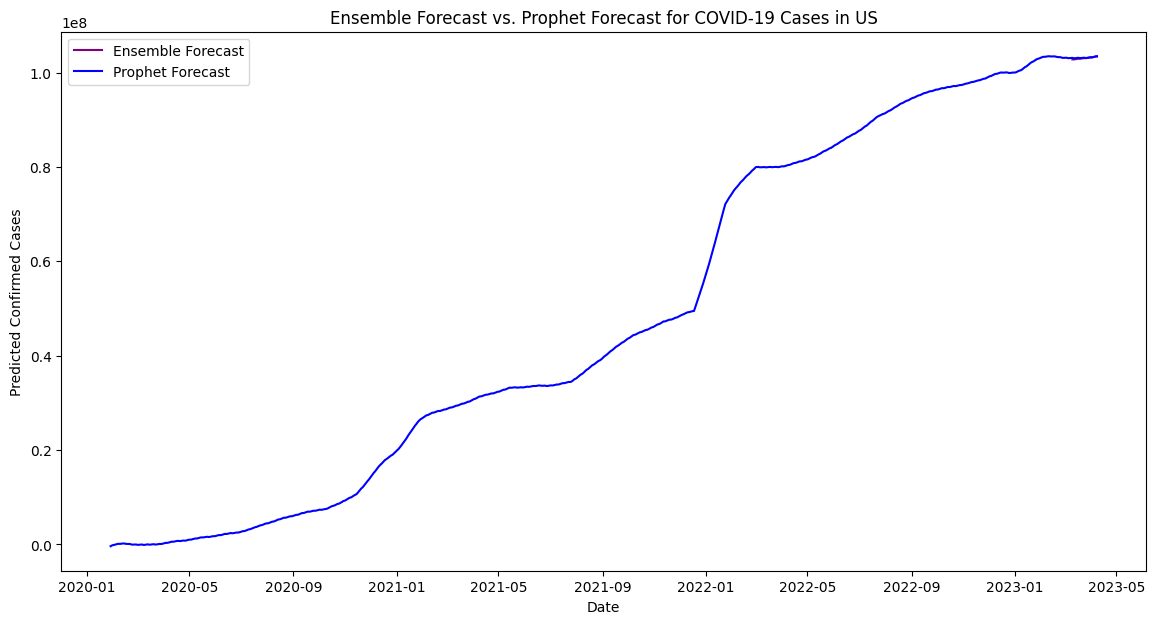

Ensemble Model MSE: 54008212574.14864


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings('ignore')

# URLs for the datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

# Load datasets
df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Melt the dataframes
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                                 var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                           var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'],
                                 var_name='Date', value_name='Recovered')

# Convert the Date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the dataframes
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Handle missing values
df.fillna(0, inplace=True)

# Select a specific country, e.g., the United States
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Create lag features for confirmed cases
for lag in range(1, 8):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)

# Create rolling statistics
country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with NaN values
country_df.dropna(inplace=True)

# Prepare data for Prophet
prophet_df = country_df[['Date', 'Confirmed']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})

# Initialize and fit the Prophet model with tuned parameters
prophet_model = Prophet(changepoint_prior_scale=0.05)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.fit(prophet_df)

# Create future dates to predict
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.title(f'COVID-19 Cases Forecast in {country} using Prophet')
plt.xlabel('Date')
plt.ylabel('Predicted Confirmed Cases')
plt.show()

# Cross-validation for the Prophet model
tscv = TimeSeriesSplit(n_splits=5)
mse_list = []

for train_index, test_index in tscv.split(prophet_df):
    train, test = prophet_df.iloc[train_index], prophet_df.iloc[test_index]
    model = Prophet(changepoint_prior_scale=0.05).fit(train)
    forecast_cv = model.predict(test[['ds']])
    mse = mean_squared_error(test['y'], forecast_cv['yhat'])
    mse_list.append(mse)

print(f'Average MSE from Cross-Validation: {np.mean(mse_list)}')

# Scaling data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(country_df['Confirmed'].values.reshape(-1, 1))

# Create sequences for LSTM
X_train, y_train = [], []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions using LSTM
predicted_cases = lstm_model.predict(X_train[-30:])

# Inverse transform predictions
predicted_cases = scaler.inverse_transform(predicted_cases)

# Combine Prophet and LSTM predictions for ensemble
ensemble_forecast = (forecast['yhat'].values[-30:] + predicted_cases.flatten()) / 2

# Plot Ensemble Forecast
plt.figure(figsize=(14, 7))
plt.plot(forecast['ds'][-30:], ensemble_forecast, label='Ensemble Forecast', color='purple')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast', color='blue')
plt.xlabel('Date')
plt.ylabel('Predicted Confirmed Cases')
plt.title(f'Ensemble Forecast vs. Prophet Forecast for COVID-19 Cases in {country}')
plt.legend()
plt.show()

# Calculate and print the MSE of the ensemble model
ensemble_mse = mean_squared_error(country_df['Confirmed'].values[-30:], ensemble_forecast)
print(f'Ensemble Model MSE: {ensemble_mse}')


Fitting 3 folds for each of 108 candidates, totalling 324 fits
XGBoost Model MSE: 72396654359682.52


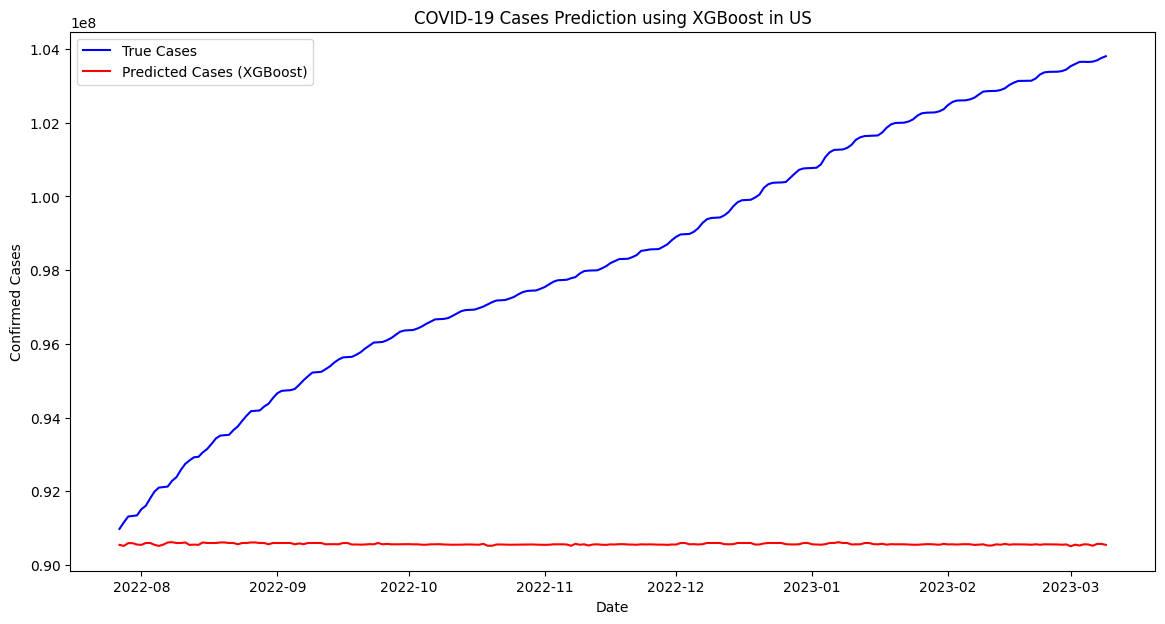

Fitting 3 folds for each of 108 candidates, totalling 324 fits
XGBoost Model MSE: 72396654359682.52


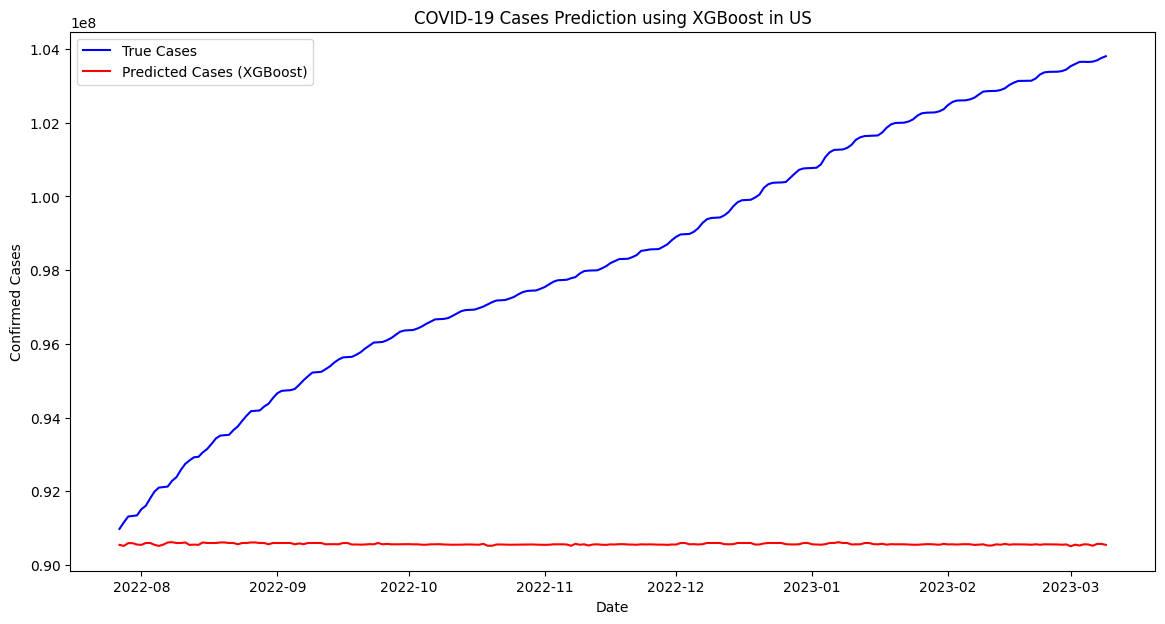

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

# Additional Feature Engineering: Rolling sums and other statistics
country_df['Confirmed_Rolling_Sum_7'] = country_df['Confirmed'].rolling(window=7).sum()
country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable and selected features
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])
for lag in range(1, 15):
    country_df[f'Log_Confirmed_Lag_{lag}'] = np.log1p(country_df[f'Confirmed_Lag_{lag}'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_log = best_model.predict(X_test)

# Inverse log transformation to get the actual values
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'XGBoost Model MSE: {mse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred):], y_pred, label='Predicted Cases (XGBoost)', color='red')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost in {country}')
plt.legend()
plt.show()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

# Additional Feature Engineering: Rolling sums and other statistics
country_df['Confirmed_Rolling_Sum_7'] = country_df['Confirmed'].rolling(window=7).sum()
country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable and selected features
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])
for lag in range(1, 15):
    country_df[f'Log_Confirmed_Lag_{lag}'] = np.log1p(country_df[f'Confirmed_Lag_{lag}'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best Model
best_model = grid_search.best_estimator_

# Make predictions
y_pred_log = best_model.predict(X_test)

# Inverse log transformation to get the actual values
y_pred = np.expm1(y_pred_log)

# Evaluate the model
mse = mean_squared_error(np.expm1(y_test), y_pred)
print(f'XGBoost Model MSE: {mse}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred):], y_pred, label='Predicted Cases (XGBoost)', color='red')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 73649540295198.4
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 272.1054
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 250.8199
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 256.8508
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 274.1752
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 253.1944
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 245.4473
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 208.1014
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 243.4642
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 244.7086
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 244.0446
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 238.4297
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 119.3255
Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.4836
Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9664
Epoch 15/50

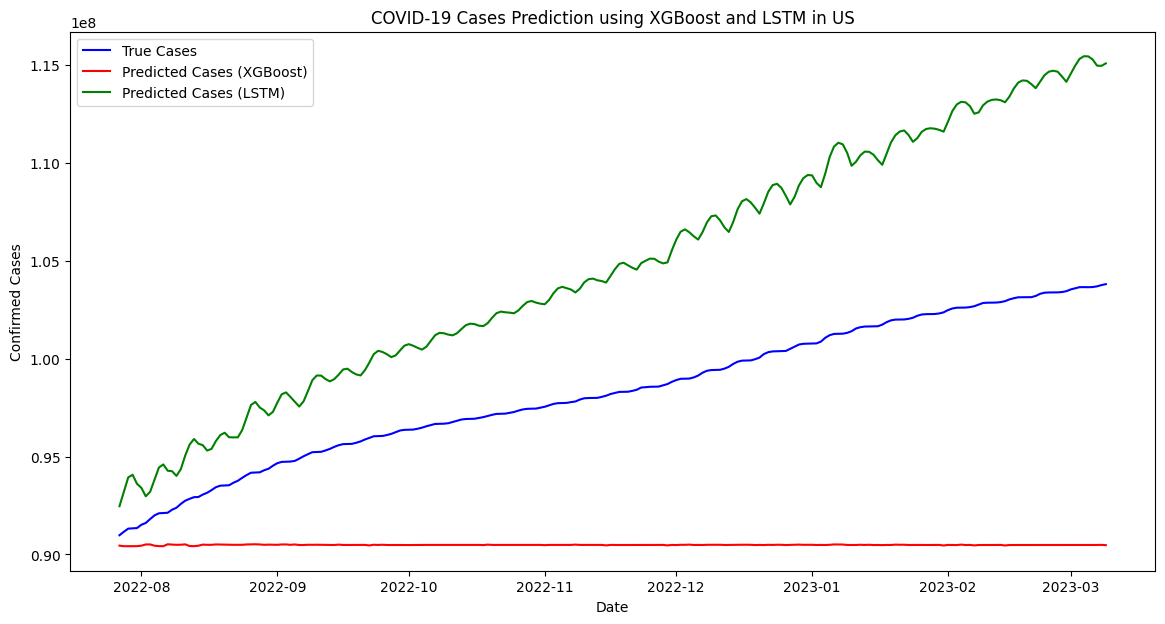

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions with XGBoost
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions with LSTM
y_pred_log_lstm = model.predict(X_test_lstm)

# Rescale predictions to match the original data scale
y_pred_log_lstm = np.expm1(y_pred_log_lstm.flatten())  # Flatten to match shape with y_test

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_log_lstm)
print(f'LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_log_lstm):], y_pred_log_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 97816584032051.22
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 306.5010 - val_loss: 273.7510
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 243.3118 - val_loss: 134.7985
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 225.0387 - val_loss: 215.7400
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 205.7199 - val_loss: 53.2539
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 139.3677 - val_loss: 21.8315
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 14.7500 - val_loss: 3.7245
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.4253 - val_loss: 0.7988
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 2.5840 - val_loss: 0.9662
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 2.7958 - val_loss: 0.0083
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 3.3281 - val_loss: 0.0163
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2.4708 - val_loss: 0.0

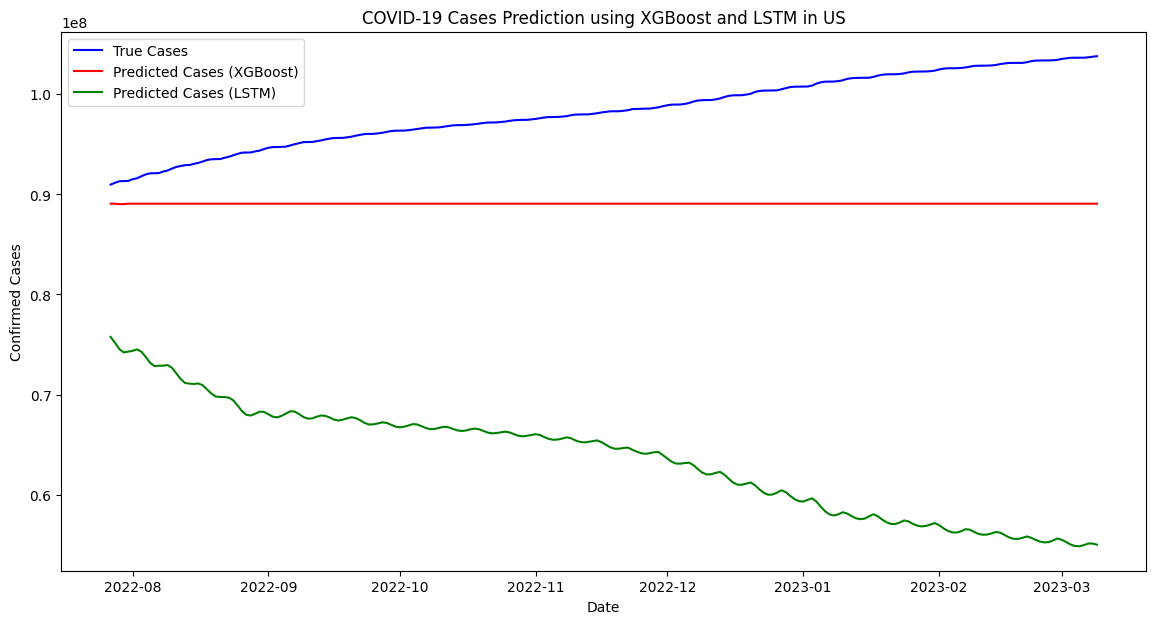

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with GridSearch for Hyperparameter Tuning
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model from GridSearch
best_xgb_model = grid_search.best_estimator_

# Make predictions with XGBoost
y_pred_log_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with LSTM
y_pred_log_lstm = model.predict(X_test_lstm)

# Flatten predictions to match shape with y_test
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 97816584032051.22
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 247.0072 - val_loss: 629.6278
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 42.7959 - val_loss: 0.1169
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 3.1123 - val_loss: 0.4647
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 4.2836 - val_loss: 0.5860
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 3.4959 - val_loss: 0.0200
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.6223 - val_loss: 1.0597
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 3.3391 - val_loss: 0.2827
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 3.5233 - val_loss: 0.6868
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.3400 - val_loss: 0.5203
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 3.8873 - val_loss: 0.0950
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 3.4526 - val_loss: 1.5493
Epoch 12/1

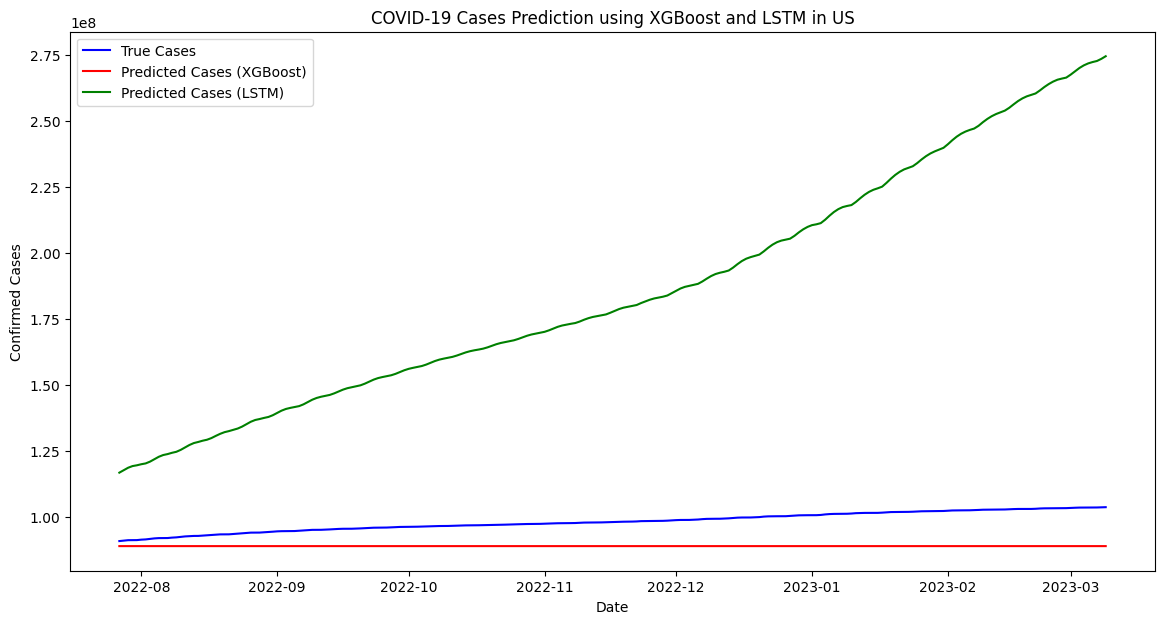

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with GridSearch for Hyperparameter Tuning
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model from GridSearch
best_xgb_model = grid_search.best_estimator_

# Make predictions with XGBoost
y_pred_log_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with LSTM
y_pred_log_lstm = model.predict(X_test_lstm)

# Flatten predictions to match shape with y_test
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 97816584032051.22
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 251.5876 - val_loss: 0.9751
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 65.1474 - val_loss: 6.3553
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 8.7868 - val_loss: 0.4873
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 5.2052 - val_loss: 0.0990
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 5.6714 - val_loss: 0.1009
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 3.8566 - val_loss: 0.0129
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 3.5651 - val_loss: 0.7035
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 3.2375 - val_loss: 1.6680
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.2063 - val_loss: 0.2979
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 2.8303 - val_loss: 0.8157
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 3.5718 - val_loss: 1.9191
Epoch 12/10

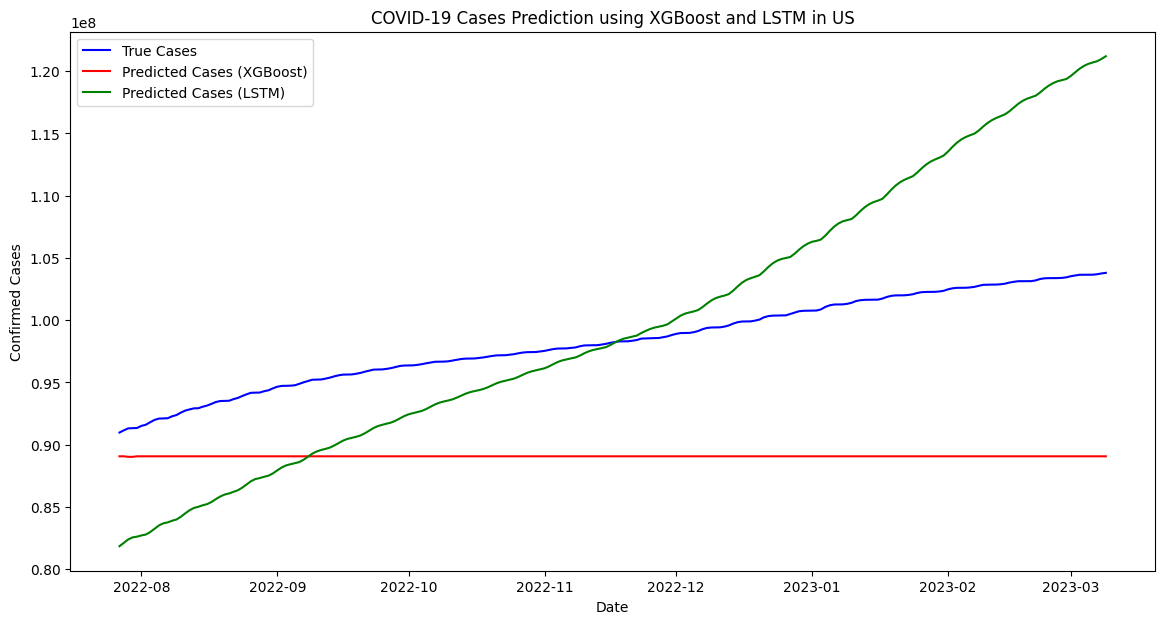

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost Model with GridSearch for Hyperparameter Tuning
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best model from GridSearch
best_xgb_model = grid_search.best_estimator_

# Make predictions with XGBoost
y_pred_log_xgb = best_xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# LSTM Model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with LSTM
y_pred_log_lstm = model.predict(X_test_lstm)

# Flatten predictions to match shape with y_test
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 73649540295198.4
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - loss: 253.3135 - val_loss: 194.2515
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - loss: 128.9392 - val_loss: 119.5211
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 79.0504 - val_loss: 88.1378
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 59.0780 - val_loss: 71.9008
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 47.2815 - val_loss: 59.5732
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 38.7669 - val_loss: 50.3853
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 32.4915 - val_loss: 42.9676
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 28.8794 - val_loss: 36.6292
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 22.8515 - val_loss: 31.3397
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 23.3503 - val_loss: 26.9191
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 19.3735

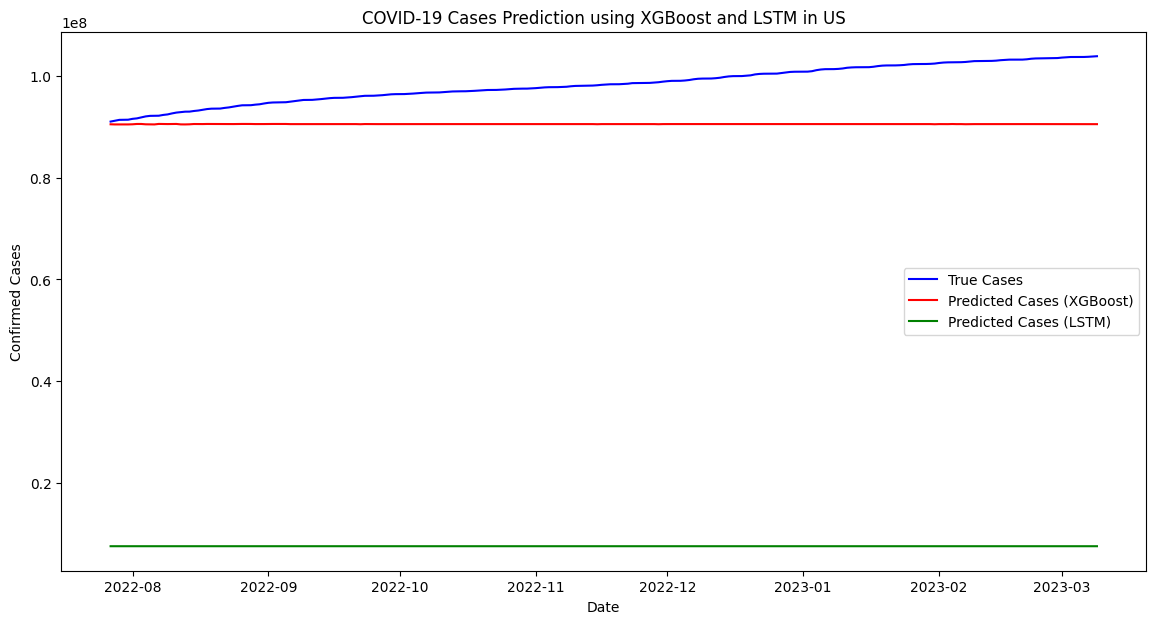

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions with XGBoost
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Improved LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with early stopping and validation split
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with the improved LSTM model
y_pred_log_lstm = model.predict(X_test_lstm)
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'Improved LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 73649540295198.4
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 343ms/step - loss: 251.7534 - val_loss: 205.7293
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 137.3723 - val_loss: 129.4596
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 85.5229 - val_loss: 97.3155
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 65.3486 - val_loss: 81.3709
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 55.1793 - val_loss: 69.5879
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 45.2201 - val_loss: 60.0351
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 39.0083 - val_loss: 51.8518
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 33.7436 - val_loss: 44.8621
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 29.2657 - val_loss: 38.9411
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 26.2720 - val_loss: 33.7870
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - loss: 21.8372

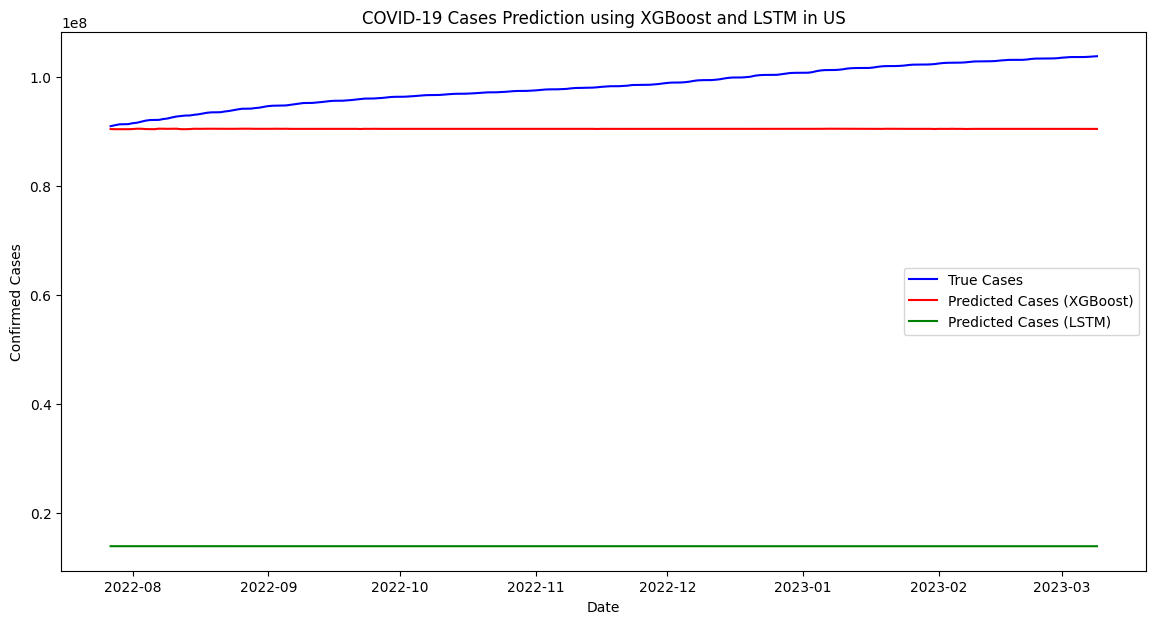

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions with XGBoost
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Improved LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with early stopping and validation split
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with the improved LSTM model
y_pred_log_lstm = model.predict(X_test_lstm)
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'Improved LSTM Model MSE: {mse_lstm}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost and LSTM in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 73649540295198.4
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 252.8267 - val_loss: 197.4513
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 128.0327 - val_loss: 114.3277
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 74.8836 - val_loss: 81.8233
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 334ms/step - loss: 54.6435 - val_loss: 66.6142
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - loss: 43.6015 - val_loss: 55.9420
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 35.7258 - val_loss: 47.2708
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 30.7367 - val_loss: 40.1113
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 27.3146 - val_loss: 34.1516
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 431ms/step - loss: 23.2173 - val_loss: 29.0989
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 20.2603 - val_loss: 24.8132
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 19.0209

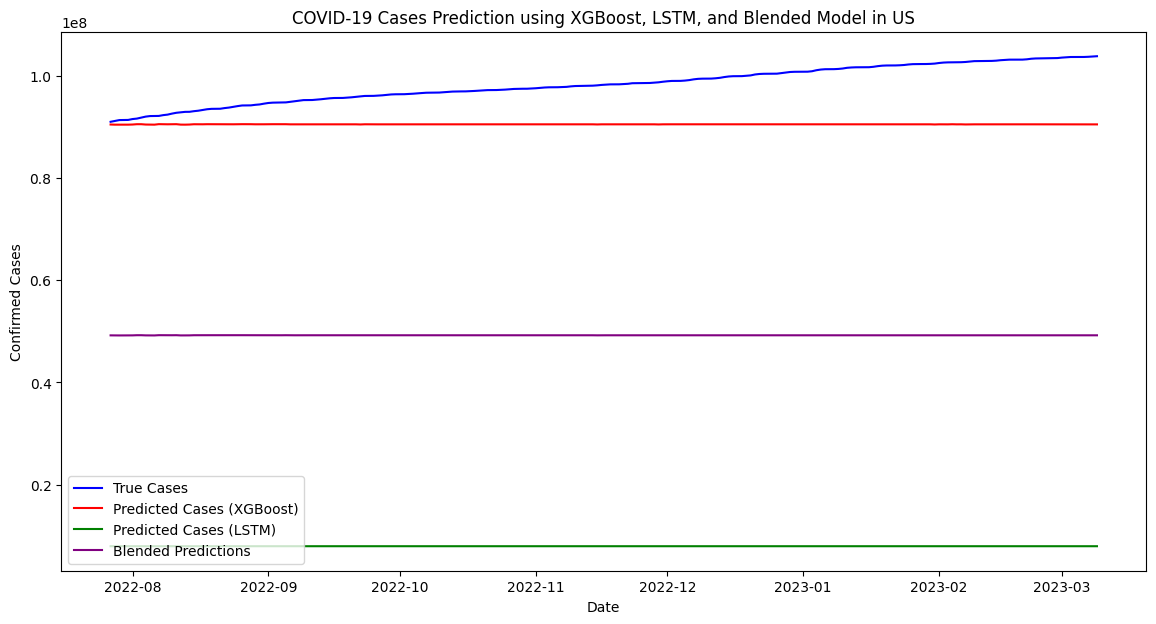

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

# Load datasets
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

df_confirmed = pd.read_csv(url_confirmed)
df_deaths = pd.read_csv(url_deaths)
df_recovered = pd.read_csv(url_recovered)

# Reshape the data
df_confirmed = df_confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Confirmed')
df_deaths = df_deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Deaths')
df_recovered = df_recovered.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], var_name='Date', value_name='Recovered')

# Convert the date column to datetime format
df_confirmed['Date'] = pd.to_datetime(df_confirmed['Date'])
df_deaths['Date'] = pd.to_datetime(df_deaths['Date'])
df_recovered['Date'] = pd.to_datetime(df_recovered['Date'])

# Merge the datasets
df = pd.merge(df_confirmed, df_deaths, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])
df = pd.merge(df, df_recovered, on=['Province/State', 'Country/Region', 'Lat', 'Long', 'Date'])

# Fill missing values with 0
df.fillna(0, inplace=True)

# Select data for a specific country
country = 'US'
country_df = df[df['Country/Region'] == country].groupby('Date').sum().reset_index()

# Feature Engineering: Creating lag features and rolling statistics
for lag in range(1, 15):
    country_df[f'Confirmed_Lag_{lag}'] = country_df['Confirmed'].shift(lag)
    country_df[f'Deaths_Lag_{lag}'] = country_df['Deaths'].shift(lag)
    country_df[f'Recovered_Lag_{lag}'] = country_df['Recovered'].shift(lag)

country_df['Confirmed_Rolling_Mean_7'] = country_df['Confirmed'].rolling(window=7).mean()
country_df['Confirmed_Rolling_Std_7'] = country_df['Confirmed'].rolling(window=7).std()

# Drop rows with missing values due to lagging
country_df.dropna(inplace=True)

# Apply log transformation to the target variable
country_df['Log_Confirmed'] = np.log1p(country_df['Confirmed'])

# Prepare features (X) and target (y)
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize features for XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8)
xgb_model.fit(X_train_scaled, y_train)

# Make predictions with XGBoost
y_pred_log_xgb = xgb_model.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Improved LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model with early stopping and validation split
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with the improved LSTM model
y_pred_log_lstm = model.predict(X_test_lstm)
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'Improved LSTM Model MSE: {mse_lstm}')

# Model Ensembling: Combining XGBoost and LSTM predictions
def blend_predictions(xgb_preds, lstm_preds):
    return (xgb_preds + lstm_preds) / 2

# Blend predictions
y_pred_blend = blend_predictions(y_pred_xgb, y_pred_lstm)
mse_blend = mean_squared_error(np.expm1(y_test), y_pred_blend)
print(f'Blended Model MSE: {mse_blend}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.plot(country_df['Date'][-len(y_pred_blend):], y_pred_blend, label='Blended Predictions', color='purple')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using XGBoost, LSTM, and Blended Model in {country}')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load and preprocess data (same as before)

# Define features and target
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features for XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
xgb_best = grid_search.best_estimator_

# Make predictions with the best XGBoost model
y_pred_log_xgb = xgb_best.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Improved LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Make predictions with LSTM
y_pred_log_lstm = model.predict(X_test_lstm)
y_pred_lstm = np.expm1(y_pred_log_lstm.flatten())

# Evaluate LSTM model
mse_lstm = mean_squared_error(np.expm1(y_test), y_pred_lstm)
print(f'Improved LSTM Model MSE: {mse_lstm}')

# ARIMA Model
arima_model = ARIMA(y, order=(5, 1, 0))
arima_fit = arima_model.fit()
y_pred_arima = arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, typ='levels')
mse_arima = mean_squared_error(np.expm1(y_test), y_pred_arima)
print(f'ARIMA Model MSE: {mse_arima}')

# Prophet Model
prophet_df = country_df[['Date', 'Confirmed']].rename(columns={'Date': 'ds', 'Confirmed': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(X_test), freq='D')
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat'][-len(X_test):]
mse_prophet = mean_squared_error(np.expm1(y_test), y_pred_prophet)
print(f'Prophet Model MSE: {mse_prophet}')

# Blend Predictions
# Model Ensembling: Combining XGBoost and LSTM predictions
def blend_predictions(xgb_preds, lstm_preds, arima_preds, prophet_preds):
    return (xgb_preds + lstm_preds + arima_preds[-len(xgb_preds):] + prophet_preds[-len(xgb_preds):]) / 4 # Only include the last 226 entries of the arima and prophet predictions to match the length of the lstm and xgb predictions. # Only include the last 226 entries of the arima and prophet predictions to match the length of the lstm and xgb predictions.

# Blend predictions
y_pred_blend = blend_predictions(y_pred_xgb, y_pred_lstm, y_pred_arima, y_pred_prophet)
mse_blend = mean_squared_error(np.expm1(y_test), y_pred_blend)
print(f'Blended Model MSE: {mse_blend}')

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(country_df['Date'][-len(y_test):], np.expm1(y_test), label='True Cases', color='blue')
plt.plot(country_df['Date'][-len(y_pred_xgb):], y_pred_xgb, label='Predicted Cases (XGBoost)', color='red')
plt.plot(country_df['Date'][-len(y_pred_lstm):], y_pred_lstm, label='Predicted Cases (LSTM)', color='green')
plt.plot(country_df['Date'][-len(y_pred_blend):], y_pred_blend, label='Blended Predictions', color='purple')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title(f'COVID-19 Cases Prediction using Various Models in {country}')
plt.legend()
plt.show()


XGBoost Model MSE: 97816584032051.22
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 411ms/step - loss: 252.8714 - val_loss: 179.2727
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 114.5907 - val_loss: 99.5123
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 64.2616 - val_loss: 68.9805
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 44.8968 - val_loss: 53.8375
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 34.2267 - val_loss: 44.3728
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 30.5386 - val_loss: 36.6699
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - loss: 25.0506 - val_loss: 30.4850
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 22.1140 - val_loss: 25.5630
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 339ms/step - loss: 18.2218 - val_loss: 21.6005
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 15.8976 - val_loss: 18.3708
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 15.202

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/rakjmylh.json


ARIMA Model MSE: 9680707781368382.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_s60dwc/n6s4i4dp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41566', 'data', 'file=/tmp/tmpz_s60dwc/rakjmylh.json', 'init=/tmp/tmpz_s60dwc/n6s4i4dp.json', 'output', 'file=/tmp/tmpz_s60dwc/prophet_modeltebuxfxg/prophet_model-20240901092630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model MSE: 95888477448550.16


ValueError: Found input variables with inconsistent numbers of samples: [226, 438]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Load and preprocess data (same as before)

# Define features and target
X = country_df.drop(['Date', 'Confirmed', 'Log_Confirmed', 'Province/State', 'Country/Region'], axis=1)
y = country_df['Log_Confirmed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features for XGBoost
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

# Hyperparameter tuning for XGBoost
xgb_model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
xgb_best = grid_search.best_estimator_

# Make predictions with the best XGBoost model
y_pred_log_xgb = xgb_best.predict(X_test_scaled)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Evaluate XGBoost model
mse_xgb = mean_squared_error(np.expm1(y_test), y_pred_xgb)
print(f'XGBoost Model MSE: {mse_xgb}')

# Rescale data for LSTM
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Improved LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='tanh'), input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
early

XGBoost Model MSE: 97816584032051.22


NameError: name 'early' is not defined